# Asian option pricing using QMC and MC
The payoff of an Asian option written on a share with price process $ (S_t)_{t \in [0,T]} $ depends on the average price over the interval $ [T_0 , T] $ with $ T_0 < T $ where $ T $ is the expirt date of the option. THe payoff of a so-called _fixed strike_ Asian call option is given by 
$$ C_T = \max\left(\frac{1}{T- T_0 } \int\limits_{T_0 }^{T} S_t dt - K , 0 \right) $$
where $ K $ is the strike price. 

To model the underlying asset price $S_t$, we will use the Heston model, which is given as  
$$
\begin{aligned}
dS_t &= r S_t dt + \sqrt{V_t} S_t (\rho dW_t^{(1)} + \sqrt{1 - \rho^2} dW_t^{(2)}) \\
dV_t &= \kappa(\theta - V_t) dt + \xi \sqrt{V_t} dW_t^{(1)} 
\end{aligned}
$$
where 
$$
\begin{aligned}
r &= \text{ risk-neutral rate of return} \\
\rho &= \text{ correlation of the two Wiener process}  \\
\theta &= \text{ the long variance, or long-run average variance of the price; as t tends to infinity, the expected value of }V_t { tends to }\theta \\
\kappa &= \text{ rate at which } V_t \text{ reverts to } \theta \\ 
\xi &= \text{ the volitality of volitality} 
\end{aligned}
$$
and $W_t^{(1)}, W_t^{(2)}$ are independent standard Brownina motion. We solve the SDE using the Euler-Maruyama method, with time step $h = T /s $ (where $s$ is the number of discretisation nodes): $ \hat{S}_0 = s_0  $ (underlying asset price at $ t = 0 $), $ \hat{V}_0 = v_0  $ (initial variance), then the solution approximated by Euler-Maruyama method would be 
$$ 
\begin{aligned}
\hat{S}_{k+1} & = \hat{S}_k + r \hat{S}_k h + \sqrt{\hat{V}_k} \hat{S}_k \left(\rho \Delta W_{k+1}^{(1)} + \sqrt{1- \rho^2} \Delta W_{k+1}^{(2)}\right) \\ 
\hat{V}_{k+1} & = \hat{V}_k + \kappa(\theta - \hat{V}_k)h + \xi \sqrt{\hat{V}_k} \Delta W_{k+1}^{(1)}
\end{aligned}
$$
for $ k = 1, \dots, s  $ where $\Delta W_{k+1}^{(j )} = W_{(k+1)h}^{(j )} - W_{kh}^{(j )} \sim \text{N}(0, h)$. 

The payoff of the Asian option is approximated by replacing the integral by a corresponding sum, i.e., 
$$ \max \left(\frac{1}{T - T_0 } \int\limits_{T_0 }^{T} S_t dt - K, 0 \right) \approx \max \left(\frac{h}{T- T_0 } \sum\limits_{k =\left\lfloor \frac{T_0}{T}s \right\rfloor + 1 }^{s} \hat{S}_k - K, 0 \right) $$
We will investigate a few ways of generating the two independent Brownian motion $ W^{(1)}, W^{(2)} $.

1. $ W^{(1)}, W^{(2)} $ are both generated using Foward constuction of Brownian motion.
2. $ W^{(1)}, W^{(2)} $ are both generated using Brownian bridge. 
3. $ W^{(1)}, W^{(2)} $ are generated by Brownian bridge and Foward construction respectively.

For simplicity, we shall assume $T_0 = 0$. 


In [33]:
# importing brownian paths function from previous weeks
import sys
sys.path.append(r'/Users/cm/Documents/Python')
from Functions.qmc import *
from scipy.stats import qmc
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# First we will define a function that returns the solutions to the variance SDE
def var_vec(rr, lvar, tsteps, vv, Bt, v0):
    """
    Input:
    rr : rate of reversion
    lvar : long variance 
    tsteps : time steps 
    vv : volitality of volitality 
    Bt : (Complete) Brownian motion, i.e that includes W_0
    v0 : initial variance

    Output:
    An array of V_k (solutions to variance SDE)
    """
    import numpy as np
    V = v0 * np.ones(shape = (1, Bt.shape[1]))
    for i in range(1, Bt.shape[0]):
        V_new_row = V[i-1] + rr * tsteps * (lvar- V[i-1]) + vv * np.multiply(np.sqrt(V[i-1]), Bt[i] - Bt[i-1])
        V_new_row[V_new_row < 0] = 0
        V = np.vstack((V, V_new_row))
    
    return V

In [35]:
# defining function for solving underlying price SDE 
def S_vec(*, rfr, corr, lvar, tsteps, vv, v0, Bt1, Bt2, rr, s0):
    """
    Input:
    rfr : risk free rate
    corr : correlation btw the two Brwonian paths
    rr : rate of reversion
    lvar : long variance 
    tsteps : time steps 
    vv : volitality of volitality 
    Bt1 : (Complete) 1st Brownian motion, i.e that includes W_0
    Bt2 : (Complete) 2nd Brownian motion, i.e that includes W_0
    v0 : initial variance
    s0 : initial price of underlying 


    Output:
    An array of S_k (solutions to asset price SDE)
    """
    import numpy as np 
    if Bt1.shape != Bt2.shape:
        raise 'The two Brownian motions have different dimensions'
    V_vec = var_vec(rr, lvar, tsteps, vv , Bt1, v0)
    S = s0 * np.ones(shape = (1, Bt1.shape[1]))
    for i in range(1, Bt1.shape[0]):
        S_new_row = S[i-1] + rfr * tsteps * S[i-1] + np.multiply(np.sqrt(V_vec[i-1]), np.multiply(S[i-1], corr * (Bt1[i] - Bt1[i-1]) + np.sqrt(1- corr ** 2) * (Bt2[i] - Bt2[i-1])))
        S = np.vstack((S, S_new_row))
    
    return S

In [36]:
# defining a function that simulates our asian option pricing 
def Asian_option_pricing(*, rfr, corr, lvar, tsteps, vv, v0, Bt1, Bt2, rr, s0, K):
    """
    Input:
    rfr : risk free rate
    corr : correlation btw the two Brwonian paths
    rr : rate of reversion
    lvar : long variance 
    tsteps : time steps 
    vv : volitality of volitality 
    Bt1 : (Complete) 1st Brownian motion, i.e that includes W_0
    Bt2 : (Complete) 2nd Brownian motion, i.e that includes W_0
    v0 : initial variance
    s0 : initial price of underlying 
    K : strike price


    Output:
    An array of simulated payoff of the asian option 
    """
    import numpy as np
    S = S_vec(s0 = s0, v0 = v0, rfr = rfr, corr = corr, rr = rr, lvar = lvar, vv = vv, tsteps = tsteps, Bt1 = Bt1, Bt2 = Bt2)
    S_new = S[1:]
    S_sum = np.mean(S_new, axis = 0) - K
    S_sum[S_sum< 0 ] = 0 
    return S_sum


In [37]:
# defining a function that output the approximated value of the asian option
def Asian_option_pricing_approx(*, rfr, corr, lvar, tsteps, vv, v0, Bt1, Bt2, rr, s0, K):
    """
    Input:
    rfr : risk free rate
    corr : correlation btw the two Brwonian paths
    rr : rate of reversion
    lvar : long variance 
    tsteps : time steps 
    vv : volitality of volitality 
    Bt1 : (Complete) 1st Brownian motion, i.e that includes W_0
    Bt2 : (Complete) 2nd Brownian motion, i.e that includes W_0
    v0 : initial variance
    s0 : initial price of underlying 
    K : strike price


    Output:
    Approximation of the payoff of asian option
    """
    import numpy as np
    S_sum_fil = Asian_option_pricing(rfr = rfr, corr = corr, lvar = lvar, tsteps = tsteps, vv= vv, v0 =v0, Bt1 = Bt1, Bt2 = Bt2, rr = rr, s0 = s0, K = K)
    return np.mean(S_sum_fil)

## Defining our parameters

In [38]:
s0 = 100 # initial underlying 
rfr = 0.03 # risk-free rate (r)
v0 = 0.3 # intial variance (v0)
corr = 0.2 # correlation btw two brownian paths (rho),  we assumed the corr btw any two paths is the same 
rr = 2 # rate of reversion (kappa)
lvar = 0.3 # long variance (theta)
vv = 0.5  # volatility of volatility (xi)
K = 100 # strike price 
T = 1 # maturity time 
steps_log2 = 7 # number of steps log 2
sims_log2 =  12#  number of simulations log 2

## Defining our Brownian paths

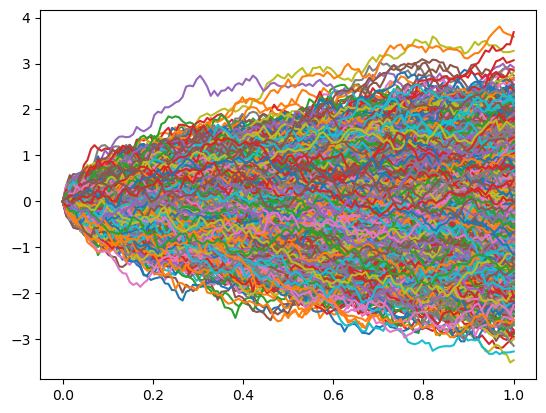

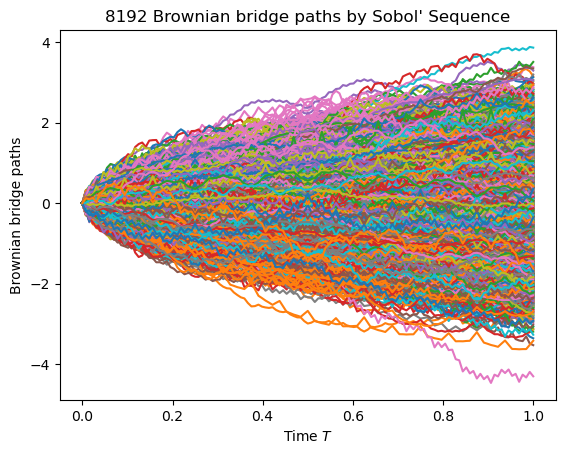

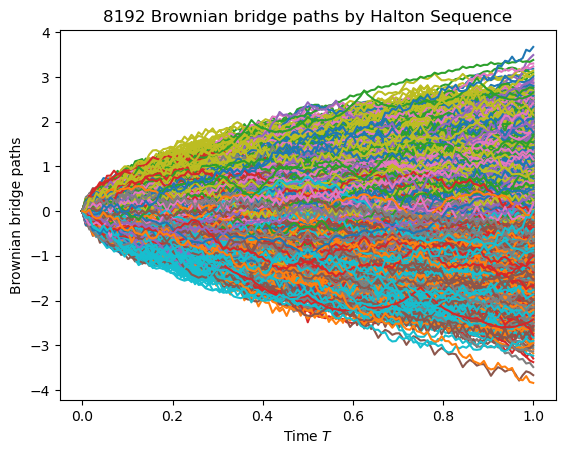

In [39]:
times1, FBM1 = BM(time = T, steps = 2 ** steps_log2, samples = 2 ** sims_log2, vis = True)
times2, FBM2 = BM(time = T, steps = 2 ** steps_log2, samples = 2 ** sims_log2, vis = False)
qmc.Sobol.reset
times3, Sobol = BB_Sobol(time = T, steps = 2 ** steps_log2, samples = 2 * (2 ** sims_log2))
Sobol1 = Sobol[:, : 2 ** sims_log2]
Sobol2 = Sobol[:,  2 ** sims_log2:]

times4, Halton = BB_Halton(time = T, steps = 2 ** steps_log2, samples = 2 * (2 ** sims_log2), vis = True)
Halton1 = Halton[:, :2 ** sims_log2]
Halton2 = Halton[:, 2 ** sims_log2:]

## Approximating the Asian option price
Now we will use different combinations of Brownian paths to approximate the price of the Asian option. We will introduce the following notation to differentiate between the combinations:

1. FF : Forward construction for both $W^{(1)}, W^{(2)}$ 
2. FS, SF : Forward construction for $W^{(1)}$ and Sobol' bridge construction for $W^{(2)}$ and vice versa.
3. FH, HF : Forward construction for $W^{(1)}$ and Halton bridge construction for $W^{(2)}$ and vice versa.
4. SS : Sobol' bridge construction for both $W^{(1)}, W^{(2)}$ 
5. SH, HS : Sobol' bridge construction for $W^{(1)}$ and Halton bridge construction for $W^{(2)}$, and vice versa. 
6. HH : Halton bridge construction for both $W^{(1)}, W^{(2)}$



In [40]:
FF = np.exp(-rfr * T) * Asian_option_pricing_approx(Bt1 = FBM1, Bt2 = FBM2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
FS = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = FBM1, Bt2 = Sobol2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
SF = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = Sobol1, Bt2 = FBM2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
FH = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = FBM1, Bt2 = Halton2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
HF = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = Halton1, Bt2 = FBM2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
SS = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = Sobol2, Bt2 = Sobol1, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
SH = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = Sobol1, Bt2 = Halton2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
HS = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = Halton1, Bt2 = Sobol2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
HH = np.exp(-rfr * T) *Asian_option_pricing_approx(Bt1 = Halton1, Bt2 = Halton2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)

In [41]:
comb = {'FF' : FF, 'FS' : FS, 'SF' : SF, 'FH' : FH, 'HF' : HF, 'SS' : SS, 'SH' :SH, 'HS' : HS, 'HH' : HH}

for x in comb:
    print('Approx of Asian option price with ', x, ': ', comb[x])


Approx of Asian option price with  FF :  13.270913340555222
Approx of Asian option price with  FS :  13.927169631147644
Approx of Asian option price with  SF :  13.140175485254387
Approx of Asian option price with  FH :  13.87599608277934
Approx of Asian option price with  HF :  13.17127752528565
Approx of Asian option price with  SS :  21.873958410573717
Approx of Asian option price with  SH :  17.10006595072155
Approx of Asian option price with  HS :  16.648156847811723
Approx of Asian option price with  HH :  18.76893115696263


In [42]:
FF_prices = Asian_option_pricing(Bt1 = FBM1, Bt2 = FBM2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
FS_prices = Asian_option_pricing(Bt1 = FBM1, Bt2 = Sobol2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
SF_prices = Asian_option_pricing(Bt1 = Sobol1, Bt2 = FBM2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
FH_prices = Asian_option_pricing(Bt1 = FBM1, Bt2 = Halton2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
HF_prices = Asian_option_pricing(Bt1 = Halton1, Bt2 = FBM2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
SS_prices = Asian_option_pricing(Bt1 = Sobol1, Bt2 = Sobol2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
SH_prices = Asian_option_pricing(Bt1 = Sobol1, Bt2 = Halton2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
HS_prices = Asian_option_pricing(Bt1 = Halton1, Bt2 = Sobol2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)
HH_prices = Asian_option_pricing(Bt1 = Halton1, Bt2 = Halton2, rfr = rfr, vv = vv, corr = corr, lvar = lvar, tsteps = times1[1], v0 = v0, s0 = s0, K = K, rr = rr)

In [43]:
max(SF_prices), max(FF_prices)

(300.21345267983264, 257.019260665111)

In [44]:
V_Sobol =var_vec(rr = rr, lvar = lvar, tsteps = times1[1], Bt = Sobol1, v0 = v0, vv = vv)
V_BM = var_vec(rr =rr, lvar = lvar, vv = vv, Bt = Halton1, v0 = v0, tsteps = times1[1])

In [45]:
V_Sobol

array([[0.3       , 0.3       , 0.3       , ..., 0.3       , 0.3       ,
        0.3       ],
       [0.27917287, 0.30546865, 0.32989308, ..., 0.30430203, 0.31778929,
        0.25692909],
       [0.28309256, 0.27488217, 0.35664032, ..., 0.25258767, 0.32427101,
        0.23700233],
       ...,
       [0.20666199, 0.34932886, 0.34851777, ..., 0.50705342, 0.21120833,
        0.12634788],
       [0.19926021, 0.38284404, 0.32438422, ..., 0.57603519, 0.20837946,
        0.13898914],
       [0.21214458, 0.37711868, 0.29735352, ..., 0.57167475, 0.1962708 ,
        0.16608315]])

In [46]:
Sobol1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07604994,  0.01996869,  0.1091541 , ...,  0.01570878,
         0.06495731, -0.15727272],
       [-0.06244477, -0.0904039 ,  0.20391753, ..., -0.17154209,
         0.08893935, -0.23855302],
       ...,
       [-1.63568794,  0.25967059,  1.16938719, ...,  0.79466014,
         0.4382206 , -1.81457792],
       [-1.67466801,  0.37568954,  1.09019585, ...,  0.99749493,
         0.41987212, -1.75871738],
       [-1.62399295,  0.36136721,  0.99661384, ...,  0.99737005,
         0.36054839, -1.62686441]])

In [47]:
a1 = np.array([1, -1, -2])
a1[a1 < 0] = 0
a1

array([1, 0, 0])

In [48]:
import numpy as np

# Heston model parameters
S0 = 100.0    # Initial stock price
K = 100.0     # Strike price
r = 0.03      # Risk-free interest rate
rho = 0.2     # Correlation between stock returns and volatility
kappa = 2.0   # Mean reversion rate of volatility
theta = 0.3   # Long-term average volatility
sigma = 0.5   # Volatility of volatility
v0 = 0.3      # Initial variance

# Asian option parameters
T = 1.0       # Time to maturity
N = 2 ** 10   # Number of Monte Carlo simulations
M = 2 ** 7    # Number of time steps (assuming daily monitoring)
dt = T / M    # Time step size
averaging_dates = np.arange(dt, T + dt, dt)  # Averaging dates

# Initialize arrays to store option payoffs
payoffs = np.zeros(N)

# Perform Monte Carlo simulation with Euler-Maruyama method
for i in range(N):
    # Initialize stock price and volatility paths
    S_path = np.zeros(M + 1)
    v_path = np.zeros(M + 1)
    S_path[0] = S0
    v_path[0] = v0

    for t in range(1, M + 1):
        # Generate independent random variables (dW1 and dW2)
        dW1 = np.sqrt(dt) * np.random.randn()
        dW2 = np.sqrt(dt) * np.random.randn()

        # Update volatility using Euler-Maruyama method
        v_path[t] = v_path[t - 1] + kappa * (theta - v_path[t - 1]) * dt + sigma * np.sqrt(v_path[t - 1]) * dW1

        # Ensure that the volatility remains non-negative
        v_path[t] = max(v_path[t], 0.0)

        # Update stock price using Euler-Maruyama method
        S_path[t] = S_path[t-1] + r * S_path[t-1] * dt + np.sqrt(v_path[t-1]) * S_path[t-1] * (rho * dW1 + np.sqrt(1-rho**2) * dW2)

    # Calculate the Asian option payoff based on the average price
    average_price = np.mean(S_path[1:])  # Exclude the initial price
    payoff = max(average_price - K, 0)
    payoffs[i] = payoff

# Calculate the option price
option_price = np.exp(-r * T) * np.mean(payoffs)

print("Asian Call Option Price (Euler-Maruyama Method):", option_price)


Asian Call Option Price (Euler-Maruyama Method): 12.845099379551685
